# Homework: Basic Artificial Neural Networks

The goal of this homework is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design of was heavily inspired by [Torch](http://torch.ch) which is the most convenient neural network environment when the work involves defining new layers. 

This homework requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- homework_modules.ipynb
- homework_differentiation.ipynb

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `Modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
# (re-)load layers
%run homework_modules_Serdyukov.ipynb

Optimizer is implemented for you. 

In [3]:
def sgd_momentum(x, dx, config, state):
    """
        This is a very ugly implementation of sgd with momentum 
        just to show an example how to store old grad in state.
        
        config:
            - momentum
            - learning_rate
        state:
            - old_grad
    """
    
    # x and dx have complex structure, old dx will be stored in a simpler one
    state.setdefault('old_grad', {})
    
    i = 0 
    for cur_layer_x, cur_layer_dx in zip(x,dx): 
        for cur_x, cur_dx in zip(cur_layer_x,cur_layer_dx):
            
            cur_old_grad = state['old_grad'].setdefault(i, np.zeros_like(cur_dx))
            
            np.add(config['momentum'] * cur_old_grad, config['learning_rate'] * cur_dx, out = cur_old_grad)
            
            cur_x -= cur_old_grad
            i += 1     

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

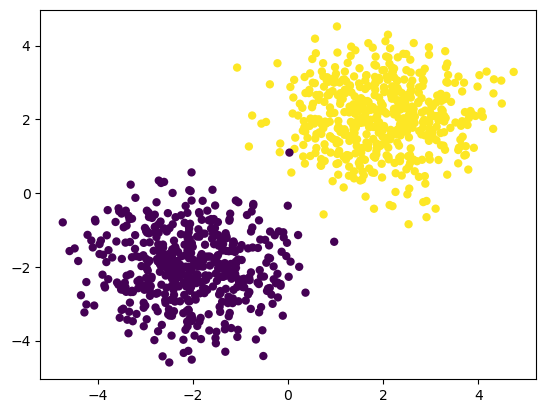

In [4]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [5]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

net = Sequential()
net.add(Linear(2, 4))
net.add(ReLU())
net.add(Linear(4, 2))
net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [6]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [7]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

## Закомментил, потому что у меня умирает ядро

### Train

Basic training loop. Examine it.

loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

## Буду использовать реализованные на торче функции, со своими не все так просто(

We are using [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. Lets start with [cool visualization](http://scs.ryerson.ca/~aharley/vis/). The most beautiful demo is the second one, if you are not familiar with convolutions you can return to it in several lectures. 

[Очень большой копипаст вот отсюда](https://github.com/FUlyankin/deep_learning_pytorch/blob/main/week02_pytorch/sem02_lifecoding.ipynb)

In [8]:
from torchvision.datasets import MNIST
import torchvision.transforms as T

In [9]:
train_set = MNIST('.MNIST', transform=T.ToTensor(), train=True, download=True)
test_set = MNIST('.MNIST', transform=T.ToTensor(), train=False, download=True)

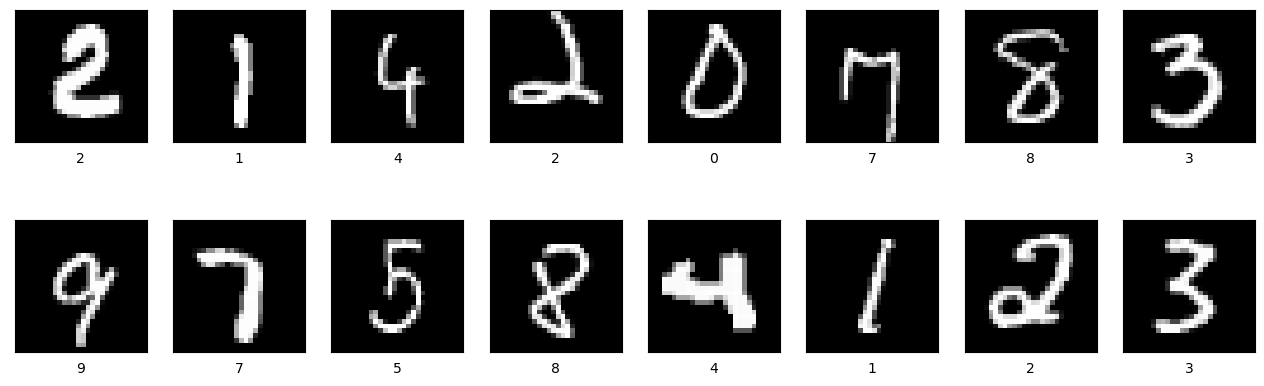

In [10]:
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols, 2.5 * rows))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(train_set))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(train_set[random_index][0].squeeze(0).numpy().reshape([28, 28]), cmap = 'gray')
        ax.set_xlabel(train_set[random_index][1])
plt.show()

In [11]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_set, shuffle=True, batch_size=64)
test_loader = DataLoader(test_set, shuffle=False, batch_size=1024)

In [12]:
from torch import nn
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm
import torch
from torch.optim.lr_scheduler import StepLR

In [13]:
class ChannelwiseScaling(nn.Module): ## использовал nn.Module
    """
       Implements linear transform of input y = \gamma * x + \beta
       where \gamma, \beta - learnable vectors of length x.shape[-1]
    """
    def __init__(self, n_out):
        super(ChannelwiseScaling, self).__init__()

        stdv = 1./np.sqrt(n_out)
        self.gamma = np.random.uniform(-stdv, stdv, size=n_out)
        self.beta = np.random.uniform(-stdv, stdv, size=n_out)
        
        self.gradGamma = np.zeros_like(self.gamma)
        self.gradBeta = np.zeros_like(self.beta)

    def updateOutput(self, input):
        self.output = input * self.gamma + self.beta
        return self.output
        
    def updateGradInput(self, input, gradOutput):
        self.gradInput = gradOutput * self.gamma
        return self.gradInput
    
    def accGradParameters(self, input, gradOutput):
        self.gradBeta = np.sum(gradOutput, axis=0)
        self.gradGamma = np.sum(gradOutput*input, axis=0)
    
    def zeroGradParameters(self):
        self.gradGamma.fill(0)
        self.gradBeta.fill(0)
        
    def getParameters(self):
        return [self.gamma, self.beta]
    
    def getGradParameters(self):
        return [self.gradGamma, self.gradBeta]
    
    def __repr__(self):
        return "ChannelwiseScaling"

In [14]:
sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})
def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Hint: logloss for MNIST should be around 0.5.

### Я не стал применять one-hot encoder к меткам классов, потому что начинают возникать технические проблемы, вместо этого использовал функцию кросс энтропии как функцию потерь, которая автоматически преобразует целочисленные метки в формат one-hot внутри функции кросс-энтропии

## Сделаю по колхозному: просто буду переопределять класс нейросетки с новыми входными параметрами для отслеживания результатов, мне так удобнее для понимания

## Relu NN

In [15]:
class MyNN(nn.Module):
    def __init__(self, in_features, num_classes, hidden_size):
        super(MyNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features, hidden_size),
            nn.BatchNorm1d(hidden_size), 
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.BatchNorm1d(hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, hidden_size // 4),
            nn.BatchNorm1d(hidden_size // 4),
            nn.ReLU(),
            nn.Linear(hidden_size // 4, num_classes),
        )

    def forward(self, X):
        X = X.view(X.size(0), -1) 
        return self.model(X)

## Параметры моей модели

In [16]:
IMG_SIZE = 28
NUM_CLASSES = 10
HIDDEN_SIZE = 64
NUM_EPOCHS = 10

## Функция для обучения нейросетки

In [17]:
def train(model, train_loader, test_loader, optimizer, criterion, scheduler=None, num_epochs=10):
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []


    for epoch in range(1, NUM_EPOCHS + 1):
        train_loss, train_accuracy = 0.0, 0.0
        
        model.train()
        for images, labels in tqdm(train_loader, desc='Training'):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            logits = model(torch.flatten(images, start_dim=1))
            # logits: batch_size x num_classes
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.shape[0]
            train_accuracy += (logits.argmax(dim=1) == labels).sum().item()

        if scheduler is not None:
            scheduler.step()

        train_loss /= len(train_loader.dataset)
        train_accuracy /= len(train_loader.dataset)
        train_losses += [train_loss]
        train_accuracies += [train_accuracy]

        test_loss, test_accuracy = 0.0, 0.0
        
        model.eval()
        for images, labels in tqdm(test_loader, desc='Validating'):
            images = images.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                logits = model(torch.flatten(images, start_dim=1))
                # logits: batch_size x num_classes
                loss = criterion(logits, labels)

            test_loss += loss.item() * images.shape[0]
            test_accuracy += (logits.argmax(dim=1) == labels).sum().item()

        test_loss /= len(test_loader.dataset)
        test_accuracy /= len(test_loader.dataset)
        test_losses += [test_loss]
        test_accuracies += [test_accuracy]
        plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)
    return (f'Train losses: {train_losses}',
            f'Train accuracies: {train_accuracies}',
            f'Test losses: {test_losses}',
            f'Test accuracies: {test_accuracies}')

## Нейросетка c функцией активации Relu

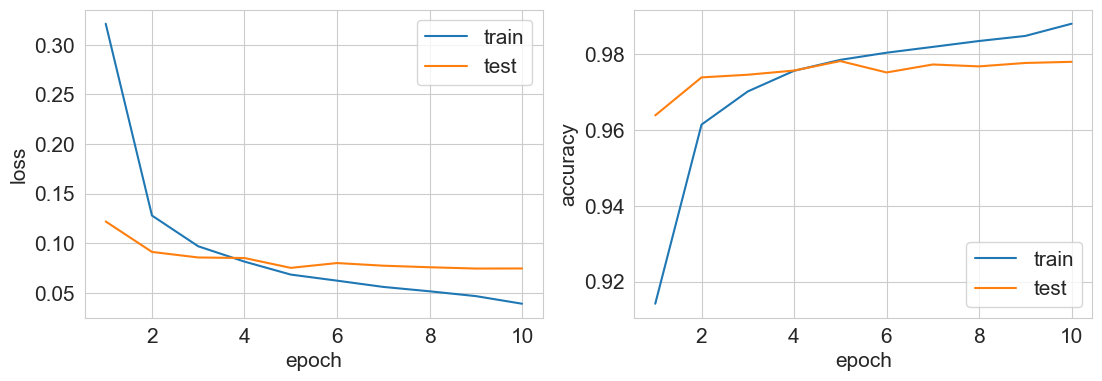

('Train losses: [0.3212668569644292, 0.12797287058134874, 0.0969916658009092, 0.08155158826013406, 0.06848314101646344, 0.06236151134123405, 0.05605380820930004, 0.05164356564829747, 0.04679204778447747, 0.039119224566593766]',
 'Train accuracies: [0.9142, 0.9613666666666667, 0.9701, 0.9755333333333334, 0.9784166666666667, 0.9803, 0.9818333333333333, 0.9833833333333334, 0.9847166666666667, 0.9879333333333333]',
 'Test losses: [0.12198875188827514, 0.09130815787315369, 0.08571840372085571, 0.08516006467342377, 0.07525438995361328, 0.08010251334905624, 0.07743604767918587, 0.07587907537221908, 0.07456459069252014, 0.07465101538896561]',
 'Test accuracies: [0.9638, 0.9738, 0.9745, 0.9756, 0.9781, 0.9751, 0.9772, 0.9767, 0.9776, 0.9779]')

In [18]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = MyNN(IMG_SIZE ** 2, NUM_CLASSES, HIDDEN_SIZE).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = None
criterion = nn.CrossEntropyLoss()  
train(model, train_loader, test_loader, optimizer, criterion, num_epochs=NUM_EPOCHS)

## Рассчёт аккураси

In [19]:
def calculate_accuracy(model, data_loader):
    model.eval()  # 
    correct = 0
    total = 0
    with torch.no_grad(): 
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)  
            total += labels.size(0)
            correct += (predicted == labels).sum().item() 
    accuracy = correct / total
    return accuracy

## Accuracy этой нейронки

In [20]:
train_accuracy = calculate_accuracy(model, train_loader)
test_accuracy = calculate_accuracy(model, test_loader)
print(f'Train Accuracy: {train_accuracy * 100:.2f}%')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Train Accuracy: 99.56%
Test Accuracy: 97.79%


## ELU NN

In [21]:
class MyNN(nn.Module):
    def __init__(self, in_features, num_classes, hidden_size):
        super(MyNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ELU(),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.BatchNorm1d(hidden_size // 2),
            nn.ELU(),
            nn.Linear(hidden_size // 2, hidden_size // 4),
            nn.BatchNorm1d(hidden_size // 4),
            nn.ELU(),
            nn.Linear(hidden_size // 4, num_classes),
        )

    def forward(self, X):
        X = X.view(X.size(0), -1)
        return self.model(X)

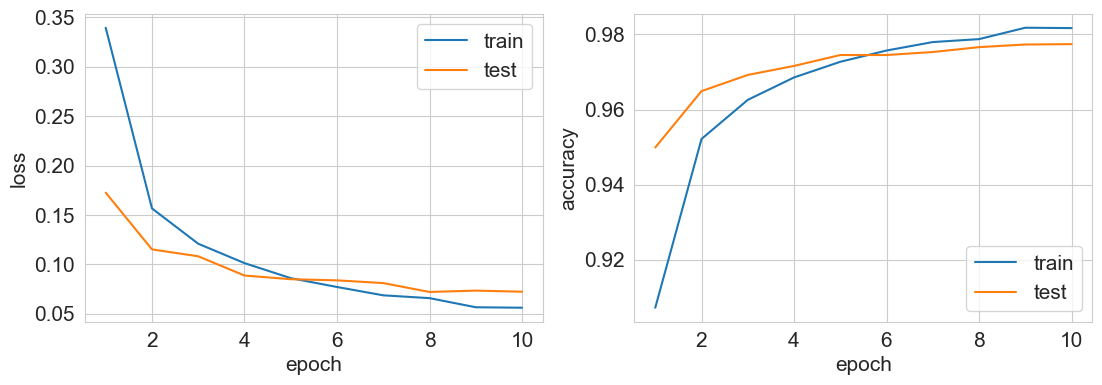

('Train losses: [0.33951853740215304, 0.1565731636961301, 0.12080812876621883, 0.1011878612478574, 0.08595615878353516, 0.0770139285599192, 0.06857964150557916, 0.0657212091098229, 0.05649360779946049, 0.05602520205304026]',
 'Train accuracies: [0.90725, 0.9521666666666667, 0.9625666666666667, 0.9685333333333334, 0.9727, 0.9757, 0.97795, 0.9787333333333333, 0.9817666666666667, 0.9816666666666667]',
 'Test losses: [0.1725140082359314, 0.11508557856082917, 0.10809651452302933, 0.0886191547870636, 0.08489172888994218, 0.083732712495327, 0.08098053631782531, 0.07197652352452279, 0.0733468447625637, 0.07223075152635575]',
 'Test accuracies: [0.9499, 0.9649, 0.9692, 0.9716, 0.9745, 0.9745, 0.9753, 0.9766, 0.9773, 0.9774]')

In [22]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = MyNN(IMG_SIZE ** 2, NUM_CLASSES, HIDDEN_SIZE).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9) # параметры оптимизации функции потерь, использую SGD
scheduler = None # шедулер не использую пока
criterion = nn.CrossEntropyLoss()  # Использую кросс-энтропию
train(model, train_loader, test_loader, optimizer, criterion, num_epochs=NUM_EPOCHS)

In [23]:
train_accuracy = calculate_accuracy(model, train_loader)
test_accuracy = calculate_accuracy(model, test_loader)
print(f'Train Accuracy: {train_accuracy * 100:.2f}%')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Train Accuracy: 99.14%
Test Accuracy: 97.74%


In [24]:
class MyNN(nn.Module):
    def __init__(self, in_features, num_classes, hidden_size):
        super(MyNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features, hidden_size),
            nn.BatchNorm1d(hidden_size), 
            nn.LeakyReLU(),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.BatchNorm1d(hidden_size // 2),
            nn.LeakyReLU(),
            nn.Linear(hidden_size // 2, hidden_size // 4),
            nn.BatchNorm1d(hidden_size // 4),
            nn.LeakyReLU(),
            nn.Linear(hidden_size // 4, num_classes),
        )

    def forward(self, X):
        X = X.view(X.size(0), -1) 
        return self.model(X)

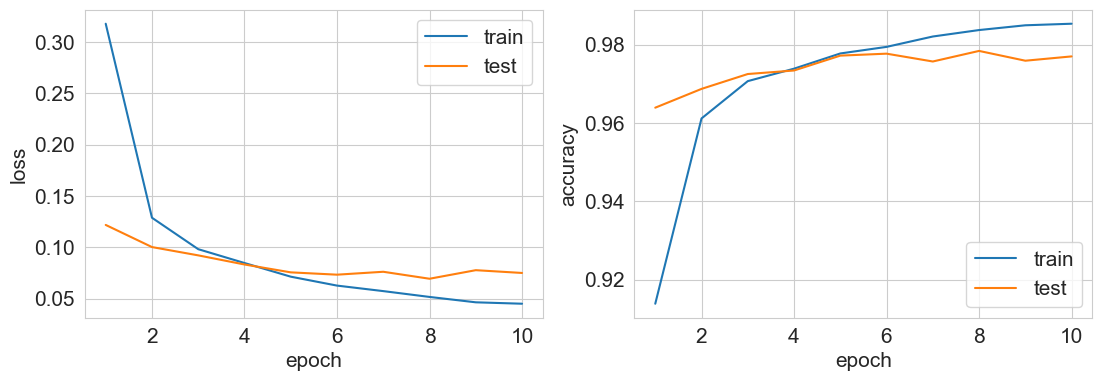

('Train losses: [0.3178055958429972, 0.12873164616425833, 0.09809311802089214, 0.08460957824736834, 0.0712981369882822, 0.0626060247555375, 0.05723417372380694, 0.051556536428506175, 0.0463140880232056, 0.044941956261421244]',
 'Train accuracies: [0.9138166666666667, 0.96115, 0.9706833333333333, 0.9738666666666667, 0.97775, 0.9794333333333334, 0.9820833333333333, 0.9837333333333333, 0.98495, 0.98535]',
 'Test losses: [0.12171805009841918, 0.10015405299663543, 0.09206508049964905, 0.08317312352657318, 0.07550699948072434, 0.07324651029109955, 0.07607993078231812, 0.06928290971517563, 0.07762744874954224, 0.07492125988006591]',
 'Test accuracies: [0.9639, 0.9687, 0.9725, 0.9734, 0.9772, 0.9777, 0.9757, 0.9784, 0.9759, 0.977]')

In [25]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = MyNN(IMG_SIZE ** 2, NUM_CLASSES, HIDDEN_SIZE).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = None
criterion = nn.CrossEntropyLoss() 
train(model, train_loader, test_loader, optimizer, criterion, num_epochs=NUM_EPOCHS)

In [26]:
train_accuracy = calculate_accuracy(model, train_loader)
test_accuracy = calculate_accuracy(model, test_loader)
print(f'Train Accuracy: {train_accuracy * 100:.2f}%')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Train Accuracy: 99.35%
Test Accuracy: 97.70%


## SoftPlus NN

In [27]:
class MyNN(nn.Module):
    def __init__(self, in_features, num_classes, hidden_size):
        super(MyNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features, hidden_size),
            nn.BatchNorm1d(hidden_size),  
            nn.Softplus(),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.BatchNorm1d(hidden_size // 2),
            nn.Softplus(),
            nn.Linear(hidden_size // 2, hidden_size // 4),
            nn.BatchNorm1d(hidden_size // 4),
            nn.Softplus(),
            nn.Linear(hidden_size // 4, num_classes),
        )

    def forward(self, X):
        X = X.view(X.size(0), -1) 
        return self.model(X)

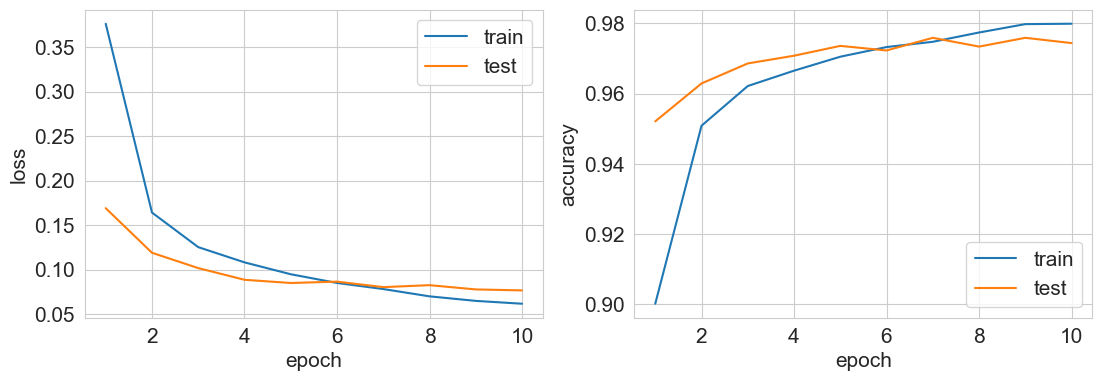

('Train losses: [0.3760907286961873, 0.16411988658110302, 0.12531188929180304, 0.10821028502384822, 0.09488435061673323, 0.0850940686489145, 0.07826919253965219, 0.07005792740806938, 0.06497012002418438, 0.061786312146609026]',
 'Train accuracies: [0.9001333333333333, 0.95085, 0.9621666666666666, 0.9665333333333334, 0.9705166666666667, 0.9732666666666666, 0.9747666666666667, 0.9774166666666667, 0.9798, 0.9799166666666667]',
 'Test losses: [0.16901663687229157, 0.11897392718791962, 0.10178079364299775, 0.08865686378479004, 0.08505407662391662, 0.0865714512348175, 0.0804076940536499, 0.08261648495197296, 0.07782828879356385, 0.07674200638532638]',
 'Test accuracies: [0.9521, 0.9629, 0.9686, 0.9708, 0.9736, 0.9723, 0.9759, 0.9734, 0.9759, 0.9744]')

In [28]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = MyNN(IMG_SIZE ** 2, NUM_CLASSES, HIDDEN_SIZE).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = None
criterion = nn.CrossEntropyLoss()
train(model, train_loader, test_loader, optimizer, criterion, num_epochs=NUM_EPOCHS)

In [29]:
train_accuracy = calculate_accuracy(model, train_loader)
test_accuracy = calculate_accuracy(model, test_loader)
print(f'Train Accuracy: {train_accuracy * 100:.2f}%')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Train Accuracy: 98.83%
Test Accuracy: 97.44%


## Попробую добавить дропаут

In [30]:
class MyNN(nn.Module):
    def __init__(self, in_features, num_classes, hidden_size, dropout_rate=0.5):
        super(MyNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features, hidden_size),
            nn.BatchNorm1d(hidden_size), 
            nn.Softplus(),
            nn.Dropout(dropout_rate), 
            nn.Linear(hidden_size, hidden_size // 2),
            nn.BatchNorm1d(hidden_size // 2),
            nn.Softplus(),
            nn.Dropout(dropout_rate), 
            nn.Linear(hidden_size // 2, hidden_size // 4),
            nn.BatchNorm1d(hidden_size // 4),
            nn.Softplus(),
            nn.Dropout(dropout_rate), 
            nn.Linear(hidden_size // 4, num_classes),
        )

    def forward(self, X):
        X = X.view(X.size(0), -1)
        return self.model(X)

## Как-то очень плохо, возможно, нужно больше слоёв для качественных результатов, но в разрезе MNIST больше слоёв как будто и не нужно

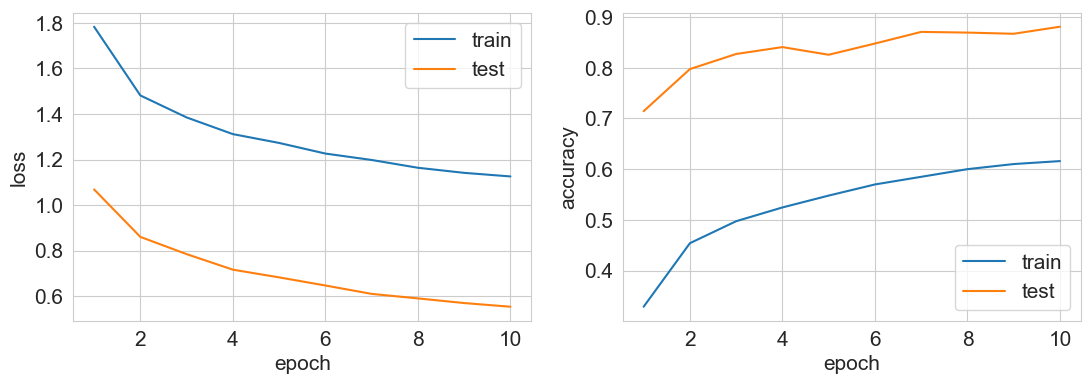

('Train losses: [1.7834374265034993, 1.4816045756657918, 1.3850593717575073, 1.3118034018834432, 1.2730052320480347, 1.2263691586176555, 1.1982401228586832, 1.1639895845413208, 1.1416405909220377, 1.1259069540341695]',
 'Train accuracies: [0.3285666666666667, 0.4539166666666667, 0.4973166666666667, 0.5244666666666666, 0.5478666666666666, 0.56985, 0.5849166666666666, 0.6000166666666666, 0.6101, 0.61595]',
 'Test losses: [1.0689450653076171, 0.8603948739051819, 0.7847591226577759, 0.7164413646697998, 0.6825870658874512, 0.6469475938796997, 0.6100758616447449, 0.5902716665267944, 0.5697980573654174, 0.5537090349197388]',
 'Test accuracies: [0.7144, 0.7975, 0.8273, 0.8409, 0.8258, 0.8479, 0.8709, 0.8695, 0.8672, 0.8811]')

In [31]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = MyNN(IMG_SIZE ** 2, NUM_CLASSES, HIDDEN_SIZE).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = None
criterion = nn.CrossEntropyLoss()
train(model, train_loader, test_loader, optimizer, criterion, num_epochs=NUM_EPOCHS)

In [32]:
train_accuracy = calculate_accuracy(model, train_loader)
test_accuracy = calculate_accuracy(model, test_loader)
print(f'Train Accuracy: {train_accuracy * 100:.2f}%')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Train Accuracy: 87.91%
Test Accuracy: 88.11%


Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

## В этой задачке выбор функции активации несильно меняет результат работы нейронки, но в целом это может улучшить конечную метрику, поэтому их подбор - важная часть, батчнормализация тоже важна! В рамках этой задачи не так сильно, но при работе с другими датасетами (задачки на регрессию и классификацию уж точно) без батчнормализации в целом не получится нормально что-то сделать, данные должны быть одного масштаба

**Finally**, use all your knowledge to build a super cool model on this dataset, do not forget to split dataset into train and validation. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [33]:
class MyNN(nn.Module):
    def __init__(self, in_features, num_classes, hidden_size):
        super(MyNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features, hidden_size),
            nn.BatchNorm1d(hidden_size),  
            nn.Softplus(),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.BatchNorm1d(hidden_size // 2),
            nn.Softplus(),
            nn.Linear(hidden_size // 2, hidden_size // 4),
            nn.BatchNorm1d(hidden_size // 4),
            nn.Softplus(),
            nn.Linear(hidden_size // 4, num_classes),
        )

    def forward(self, X):
        X = X.view(X.size(0), -1) 
        return self.model(X)

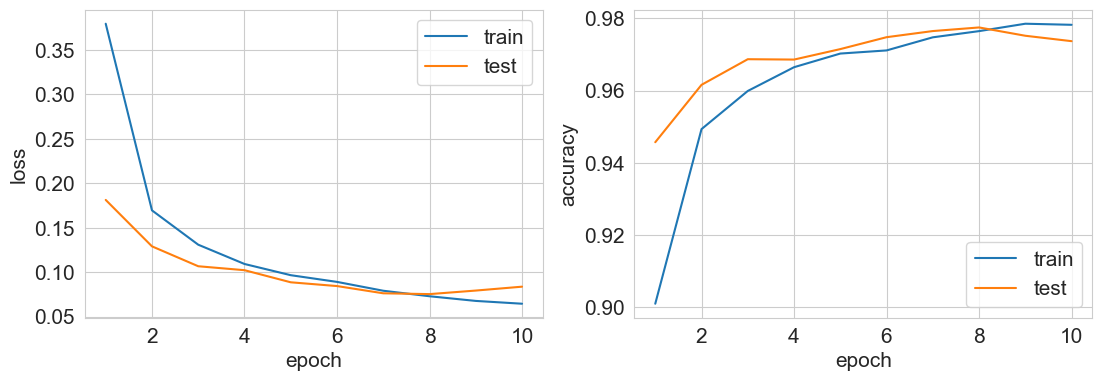

('Train losses: [0.37943301388422646, 0.16951084437767663, 0.13092033537626266, 0.10923806701848904, 0.09661973514755567, 0.08908538147608439, 0.07912768635849159, 0.07293887929568688, 0.06768895454009374, 0.06453440132836501]',
 'Train accuracies: [0.90095, 0.9493333333333334, 0.9599, 0.9664833333333334, 0.9702666666666667, 0.9711333333333333, 0.9747666666666667, 0.9764833333333334, 0.9785333333333334, 0.9782333333333333]',
 'Test losses: [0.18126936569213867, 0.12905718450546264, 0.10668148643970489, 0.10224581360816956, 0.08863254415988922, 0.08439495755434036, 0.07625831961631775, 0.07534643248319625, 0.07933382805585862, 0.08370251570940018]',
 'Test accuracies: [0.9457, 0.9616, 0.9687, 0.9686, 0.9715, 0.9748, 0.9765, 0.9775, 0.9752, 0.9737]')

In [34]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = MyNN(IMG_SIZE ** 2, NUM_CLASSES, HIDDEN_SIZE).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = None
criterion = nn.CrossEntropyLoss()
train(model, train_loader, test_loader, optimizer, criterion, num_epochs=NUM_EPOCHS)

Print here your accuracy. It should be around 90%.

## Выбрал эти параметры, потому что разница на тесте и трейне очень маленькая (<1,5%)

In [35]:
train_accuracy = calculate_accuracy(model, train_loader)
test_accuracy = calculate_accuracy(model, test_loader)
print(f'Train Accuracy: {train_accuracy * 100:.2f}%')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Train Accuracy: 98.72%
Test Accuracy: 97.37%


# Autoencoder

Now we are going to build a cool model, named autoencoder. The aim is simple: **encode** the data to a lower dimentional representation. Why? Well, if we can **decode** this representation back to original data with "small" reconstuction loss then we can store only compressed representation saving memory. But the most important thing is -- we can reuse trained autoencoder for classification. 
<img src="autoencoder.png">

Picture from this [site](http://multithreaded.stitchfix.com/blog/2015/09/17/deep-style/).

Now implement an autoencoder:

Build it such that dimetionality inside autoencoder changes like that: 

$$784 \text{ (data)} -> 512 -> 256 -> 128 -> 30 -> 128 -> 256 -> 512 -> 784$$

Use `MSECriterion` to score the reconstruction. Use `BatchNormalization` (followed by `ChannelwiseScaling` as usual) between `Linear` and `ReLU`. You may not use nonlinearity in bottleneck layer.

You may train it for 9 epochs with batch size = 256, initial lr = 0.1 droping by a factor of 2 every 3 epochs. The reconstruction loss should be about 6.0 and visual quality decent already.
Do not spend time on changing architecture, they are more or less the same. 

In [36]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 30) 
        )
        self.decoder = nn.Sequential(
            nn.Linear(30, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Sigmoid() 
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [37]:
def train_autoencoder(autoencoder, train_loader, optimizer, criterion, scheduler, num_epochs):
    for epoch in range(num_epochs):
        autoencoder.train()
        running_loss = 0.0
        loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
        
        for i, (images, _) in loop:  
            images = images.to(device)
            optimizer.zero_grad()
            reconstructed = autoencoder(images.view(images.size(0), -1))
            loss = criterion(reconstructed, images.view(images.size(0), -1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
            loop.set_description(f"Эпоха [{epoch+1}/{num_epochs}]")
            loop.set_postfix(loss=loss.item())
        
        scheduler.step()
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Эпоха [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
        
    print('Обучение завершено')

In [38]:
autoencoder = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(autoencoder.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=3, gamma=0.5)

In [39]:
train_autoencoder(autoencoder, train_loader, optimizer, criterion, scheduler, num_epochs=9)

  0%|          | 0/938 [00:00<?, ?it/s]

Эпоха [1/9], Loss: 0.0600


  0%|          | 0/938 [00:00<?, ?it/s]

Эпоха [2/9], Loss: 0.0349


  0%|          | 0/938 [00:00<?, ?it/s]

Эпоха [3/9], Loss: 0.0296


  0%|          | 0/938 [00:00<?, ?it/s]

Эпоха [4/9], Loss: 0.0270


  0%|          | 0/938 [00:00<?, ?it/s]

Эпоха [5/9], Loss: 0.0256


  0%|          | 0/938 [00:00<?, ?it/s]

Эпоха [6/9], Loss: 0.0245


  0%|          | 0/938 [00:00<?, ?it/s]

Эпоха [7/9], Loss: 0.0236


  0%|          | 0/938 [00:00<?, ?it/s]

Эпоха [8/9], Loss: 0.0232


  0%|          | 0/938 [00:00<?, ?it/s]

Эпоха [9/9], Loss: 0.0227
Обучение завершено


Some time ago NNs were a lot poorer and people were struggling to learn deep models. To train a classification net people were training autoencoder first (to train autoencoder people were pretraining single layers with [RBM](https://en.wikipedia.org/wiki/Restricted_Boltzmann_machine)), then substituting the decoder part with classification layer (yeah, they were struggling with training autoencoders a lot, and complex techniques were used at that dark times). We are going to this now, fast and easy.  

In [40]:
# Extract inner representation for train and validation, 
# you should get (n_samples, 30) matrices
# Your code goes here. ################################################

# Now build a logistic regression or small classification net
#cnet = Sequential()
#cnet.add(Linear(30, 2))
#cnet.add(LogSoftMax())

# Learn the weights
# Your code goes here. ################################################

# Now chop off decoder part
# (you may need to implement `remove` method for Sequential container) 
# Your code goes here. ################################################

# And add learned layers ontop.
#autoenc.add(cnet[0])
#autoenc.add(cnet[1])

# Now optimize whole model
# Your code goes here. ################################################

* What do you think, does it make sense to build real-world classifiers this way ? Did it work better for you than a straightforward one? Looks like it was not the same ~8 years ago, what has changed beside computational power? 

Run PCA with 30 components on the *train set*, plot original image, autoencoder and PCA reconstructions side by side for 10 samples from *validation set*.
Probably you need to use the following snippet to make aoutpencoder examples look comparible.

In [41]:
# np.clip(prediction,0,1)
#
# Your code goes here. ################################################